In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from torch.utils.tensorboard import SummaryWriter
from scipy.stats import entropy

### Preparing Data

In [2]:
# Download training data from open datasets.
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

In [3]:
batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


In [4]:
classes = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

### Model

In [5]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)

Using cuda device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [6]:
import tensorflow as tf

print(tf.test.is_gpu_available())
torch.cuda.get_device_name(torch.device('cuda:0'))

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
True


'NVIDIA GeForce RTX 2070'

In [7]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)
#writer = SummaryWriter('runs/fashion_mnist_experiment_1')

#### Pred Hist

In [8]:
prediction_history = torch.zeros(0,60000,10) ##
prediction_history = prediction_history.to(device) ##

### Train Function

In [9]:
def train(dataloader, model, loss_fn, optimizer):

  global prediction_history ##

  size = len(dataloader.dataset)
  model.train()

  epoch_pred=torch.zeros(0,10) ### 10 = class number
  epoch_pred = epoch_pred.to(device) ###

  for batch, (X, y) in enumerate(dataloader):
    X, y = X.to(device), y.to(device)

    # Compute prediction error
    pred = model(X)

    ##records = aum_calculator.update(pred, y, classes) ### From Paper

    epoch_pred=torch.cat((epoch_pred,pred)) ###

    loss = loss_fn(pred, y)

    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if batch % 100 == 0:
        loss, current = loss.item(), batch * len(X)
        print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

  prediction_history =torch.cat((prediction_history,torch.unsqueeze(epoch_pred, 0)))#

### Test Function

In [10]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

### Training & Evaluating Model

In [11]:
epochs = 100
#print(prediction_history.shape)

prediction_history = torch.zeros(0,60000,10) ##
prediction_history = prediction_history.to(device) ##

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.297132  [    0/60000]
loss: 2.289246  [ 6400/60000]
loss: 2.272190  [12800/60000]
loss: 2.262402  [19200/60000]
loss: 2.263222  [25600/60000]
loss: 2.224083  [32000/60000]
loss: 2.228675  [38400/60000]
loss: 2.198873  [44800/60000]
loss: 2.186694  [51200/60000]
loss: 2.158573  [57600/60000]
Test Error: 
 Accuracy: 51.4%, Avg loss: 2.158180 

Epoch 2
-------------------------------
loss: 2.162415  [    0/60000]
loss: 2.155534  [ 6400/60000]
loss: 2.108146  [12800/60000]
loss: 2.112364  [19200/60000]
loss: 2.078966  [25600/60000]
loss: 2.013503  [32000/60000]
loss: 2.032900  [38400/60000]
loss: 1.964207  [44800/60000]
loss: 1.957292  [51200/60000]
loss: 1.878737  [57600/60000]
Test Error: 
 Accuracy: 59.3%, Avg loss: 1.890916 

Epoch 3
-------------------------------
loss: 1.922752  [    0/60000]
loss: 1.890466  [ 6400/60000]
loss: 1.793666  [12800/60000]
loss: 1.812686  [19200/60000]
loss: 1.720603  [25600/60000]
loss: 1.672260  [32000/600

In [12]:
model.eval()
x, y = test_data[0][0], test_data[0][1]

if device =="cuda":
  x=x.to(device)

with torch.no_grad():
    pred = model(x)
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')

Predicted: "Ankle boot", Actual: "Ankle boot"


### Influence Functions

In [13]:
import sys
sys.path.append('..')

In [14]:
from VTDA import inf

In [15]:
inf.init_logging()

#config = {'outdir': "C:/Users/Gamegaraj/Desktop",
#          'seed': 42,
#          'gpu': 0,
#          'dataset': 'MNIST',
#          'num_classes': 10,
#          'test_sample_num': 1,
#          'test_start_index': 0,
#          'recursion_depth': 1,
#          'r_averaging': 1,
#          'scale': None,
#          'damp': None,
#          'calc_method': 'img_wise',
#          'log_filename': None,}


config = inf.get_default_config()
config['outdir'] = "C:/Users/Gamegaraj/Desktop"
config['gpu'] = 0
influences = inf.calc_img_wise(config, model, train_dataloader , test_dataloader)

2022-09-06 14:47:35,325: Running on: 1 images per class.
2022-09-06 14:47:35,325: Starting at img number: 0 per class.
Calc. s_test recursions: [=================================================] 1 / 1
Averaging r-times: [=======================================================] 1 / 1


C:\Users\Gamegaraj\Desktop\Visual Training Dynamics Analysis\VTDA\influence_function\influence_function.py:70: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  y = torch.nn.functional.log_softmax(y)


Calc. influence function: [========================================] 59999 / 60000000
Calc. influence function: [========================================] 60000 / 60000
Calc. s_test recursions: [=================================================] 1 / 1 10
Averaging r-times: [=======================================================] 1 / 1
Calc. influence function: [========================================] 59999 / 60000000
Calc. influence function: [========================================] 60000 / 60000
Calc. s_test recursions: [=================================================] 1 / 1 10
Averaging r-times: [=======================================================] 1 / 1
Calc. influence function: [========================================] 59999 / 60000000
Calc. influence function: [========================================] 60000 / 60000
Calc. s_test recursions: [=================================================] 1 / 1 10
Averaging r-times: [=================================================

For each class, influence function is used for all images.
10 influence outputs are available.

In [16]:
for i in range(2):
    print(influences[str(i)]['influence'])
    print(influences[str(i)]['harmful'])
    print(influences[str(i)]['helpful'])

[-2.5116394681390375e-05, 3.108678129137843e-06, -4.5610853703692555e-05, 9.113740816246718e-05, -0.00016024881915654987, -4.55909730590065e-06, 0.00021756233763881028, -0.0004753093817271292, 1.644130861677695e-06, 5.9501779503534635e-08, 9.96593644231325e-06, -4.105093830730766e-05, 5.731582859880291e-05, -0.00024284687242470682, 1.970269477169495e-05, -7.639860268682241e-05, 1.7238383165363302e-08, 2.4666955141583458e-05, -0.00012394470104482025, 0.00010992421448463574, 6.457556764871697e-07, -2.1450156850733038e-07, 0.000327101704897359, 6.3282658402386e-07, 0.0006268967990763485, -0.00011501702829264104, 1.8692091543925926e-05, -0.0001379330933559686, 0.00024328453582711518, 0.00013255236262921244, -1.6055566902650753e-06, 1.9904455257346854e-06, -0.0001922281226143241, -8.140108548104763e-05, 2.182772550440859e-05, 5.120763944432838e-06, -5.725674418499693e-05, 1.1270294635323808e-05, 6.466294166784792e-10, -0.00011755282321246341, -3.355356602696702e-05, 0.00021828013996127993, 

In [17]:
influence_list = influences["1"]['influence']
harmful_list = influences["1"]['harmful']
helpful_list = influences["1"]['helpful']

In [18]:
influence = np.asarray(influence_list)
harmful = np.asarray(harmful_list)
helpful = np.asarray(helpful_list)

In [19]:
# creating the dataframe
df_influence = pd.DataFrame(data = influence,
                      columns = ["influence"])



In [20]:
df_influence.shape

(60000, 1)

Harmful
Harmful is a list of numbers, which are the IDs of the training data samples ordered by harmfulness. If the influence function is calculated for multiple test images, the harmfulness is ordered by average harmfullness to the prediction outcome of the processed test samples.

Helpful
Helpful is a list of numbers, which are the IDs of the training data samples ordered by helpfulness. If the influence function is calculated for multiple test images, the helpfulness is ordered by average helpfulness to the prediction outcome of the processed test samples.

In [21]:
harmful

array([ 4836, 39735, 51216, 24345, 58442, 22949,   612, 36473, 54352,
        8813, 15471,  5595, 41893, 27350, 16533, 19988, 17836, 42243,
       52747, 33242,  2743, 13903, 58156, 12210, 58557, 44222, 42938,
       56042, 39425, 37056, 31654,  9640,  7632, 19278, 33904, 52325,
        8534, 31755, 40873, 17295, 48658, 21015, 45795, 16258,  2069,
       23352, 33982,  7917, 17778, 57626, 43195, 49730, 57885, 14465,
       52632, 22209, 47254, 44234, 51874, 46606, 21038, 37951, 53502,
       59709, 53398, 22773,  3618, 13998, 47042, 33417, 14978, 51023,
       39525, 12923, 11845, 53310, 30106, 11714, 48323, 19962, 21575,
        8137,  4501, 11551, 44514, 39401, 27678,  6806, 50902, 18886,
       22456, 55649, 25677,  4628, 45786, 43899, 49941, 39339, 26533,
       19899, 29598,  4587, 49398, 59752,  6611,  8015,  6261, 45175,
       13613, 47888,  2490,  9441, 35562, 49939, 39281, 32783, 58647,
       22285, 54969,  5106, 40557, 59543, 23881, 54247, 19370, 16808,
        5398, 12428,

In [22]:
helpful

array([48756, 50700, 16276, 10097,   502, 56448, 18542, 45222, 14728,
        6082, 28689, 19809,  3530, 10733, 49543, 59203, 20487, 29389,
       47910, 51636, 53973, 30497, 33977, 36782, 33881, 18984, 44045,
       25017, 56918,  2987,  2863, 26226,  6063,  7094, 41299, 51224,
       28633, 18740, 58483, 23379, 17109, 45797, 31524,  2079, 52615,
       25559, 13365, 40822, 49396,  9019, 12371,   169,  1156,  8862,
       43852, 32882, 10653,  7348, 13839,  7209, 39199, 11877, 11392,
       32870, 44746, 32469, 38904, 13792, 24305, 58129, 35747,  8251,
       15061, 38970, 20314, 21445,  5649, 57905, 27930, 25197, 20227,
        4382, 37683, 42342, 53691, 56127, 56930, 33590, 24067, 31239,
       31659, 20585, 49251, 25780, 43322, 57713, 44238, 16807, 55557,
        6090, 40852, 42603, 28145, 30673, 12124, 41892, 23069, 44922,
       19480, 50312, 53963, 14340, 36526, 11170,  1206, 50351,  3725,
       52157, 12720, 22622, 21719, 22599, 50616, 54839, 17306, 27618,
       36571, 18396,

### Influence Visualization

In [23]:
from VTDA import dmap

In [24]:
prediction_history.shape

torch.Size([100, 60000, 10])

In [25]:
num_pred_hist=(torch.softmax(prediction_history,dim=2)).detach().cpu().numpy()

In [26]:
confidence_means=torch.mean(torch.softmax(prediction_history, dim = 2),0)
std=torch.std(torch.softmax(prediction_history, dim = 2),0)
targets=training_data.targets.cpu().numpy()

In [27]:
df = pd.DataFrame(targets, columns=["Label"])
dmap.calculate_confidence(prediction_history,targets,df)
dmap.calculate_variability(prediction_history,targets,df)
dmap.calculate_correctness(prediction_history,epochs,targets,df)
df["influence"] = df_influence

[[7 8 9 ... 9 9 9]
 [3 0 0 ... 0 0 0]
 [2 2 1 ... 0 0 0]
 ...
 [3 3 3 ... 3 3 3]
 [2 0 0 ... 0 0 0]
 [7 7 7 ... 5 5 5]]


In [28]:
prediction_history.shape

torch.Size([100, 60000, 10])

In [29]:
df.head()

,Label,confidence,variability,correctness,influence
0,9,0.925039,0.168843,0.98,-2.682421e-07
1,0,0.929578,0.172348,0.99,2.354699e-05
2,0,0.219414,0.075517,0.21,7.230868e-04
3,3,0.217678,0.047911,0.01,-3.622133e-04
4,0,0.091803,0.026491,0.00,1.463759e-03


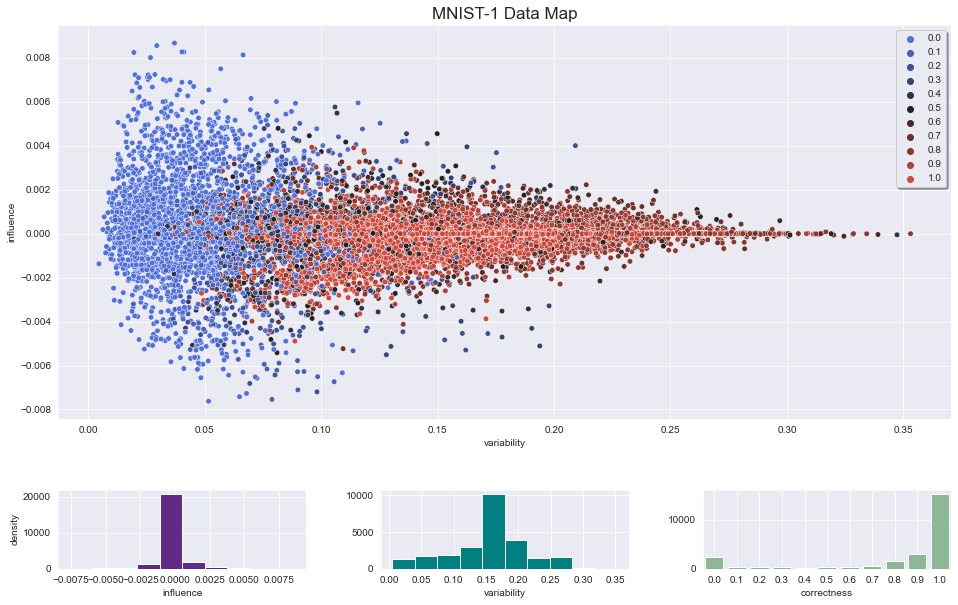

In [30]:
dmap.scatter_it(df, model="MNIST",title='1', show_hist=True, main_metric="variability", other_metric="influence")

In [31]:
len(influences["1"]["influence"])

60000

#### Top 7 Harmful Data and Their Images

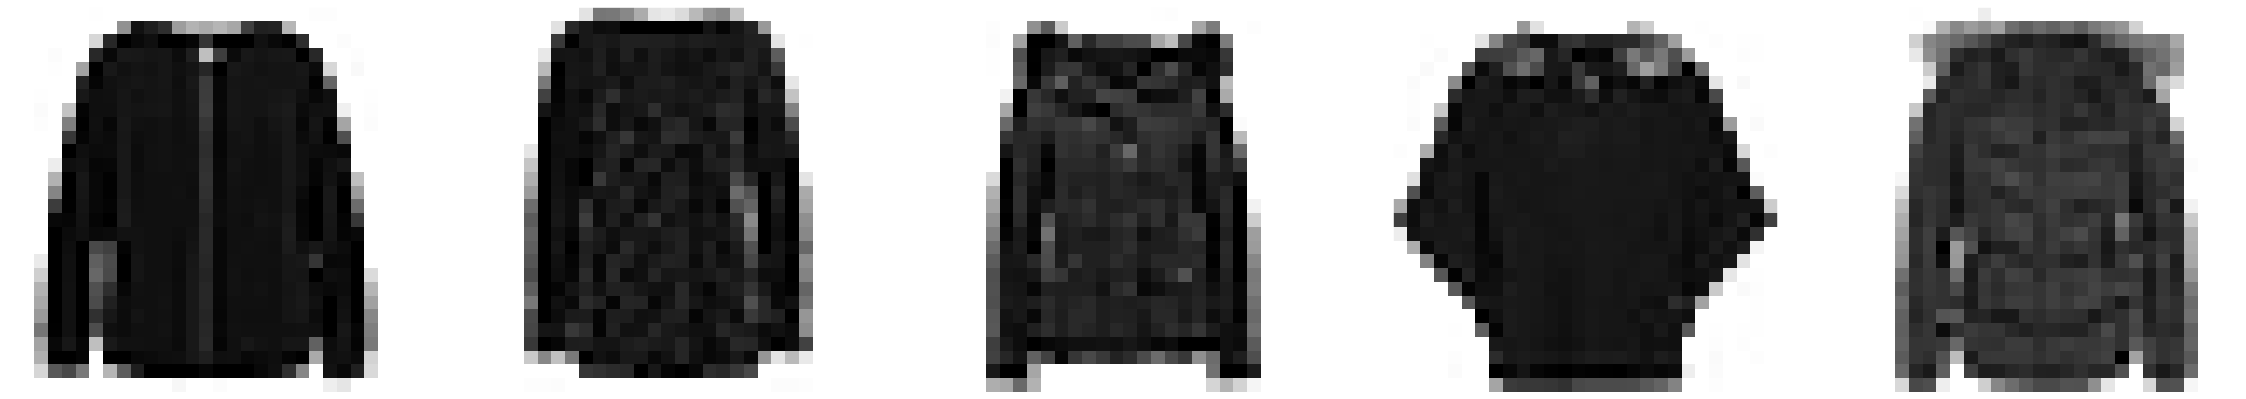

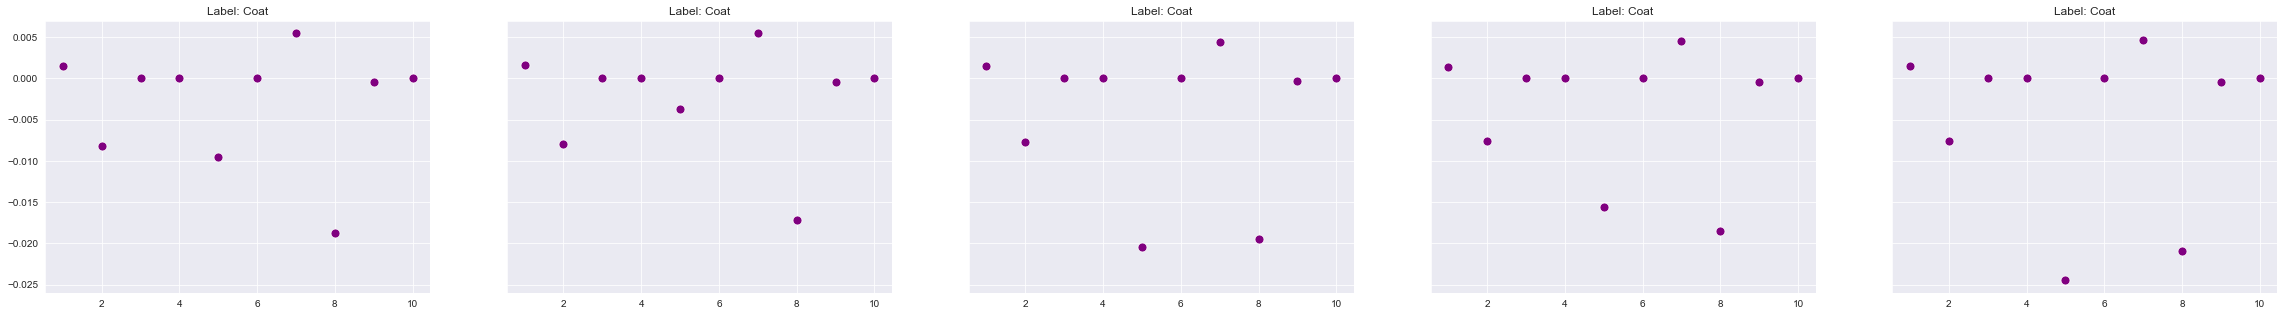

In [32]:
inf.plot_top_influencers(harmful,classes,training_data,influences,5)

#### Top 7 Helpful Data and Their Images

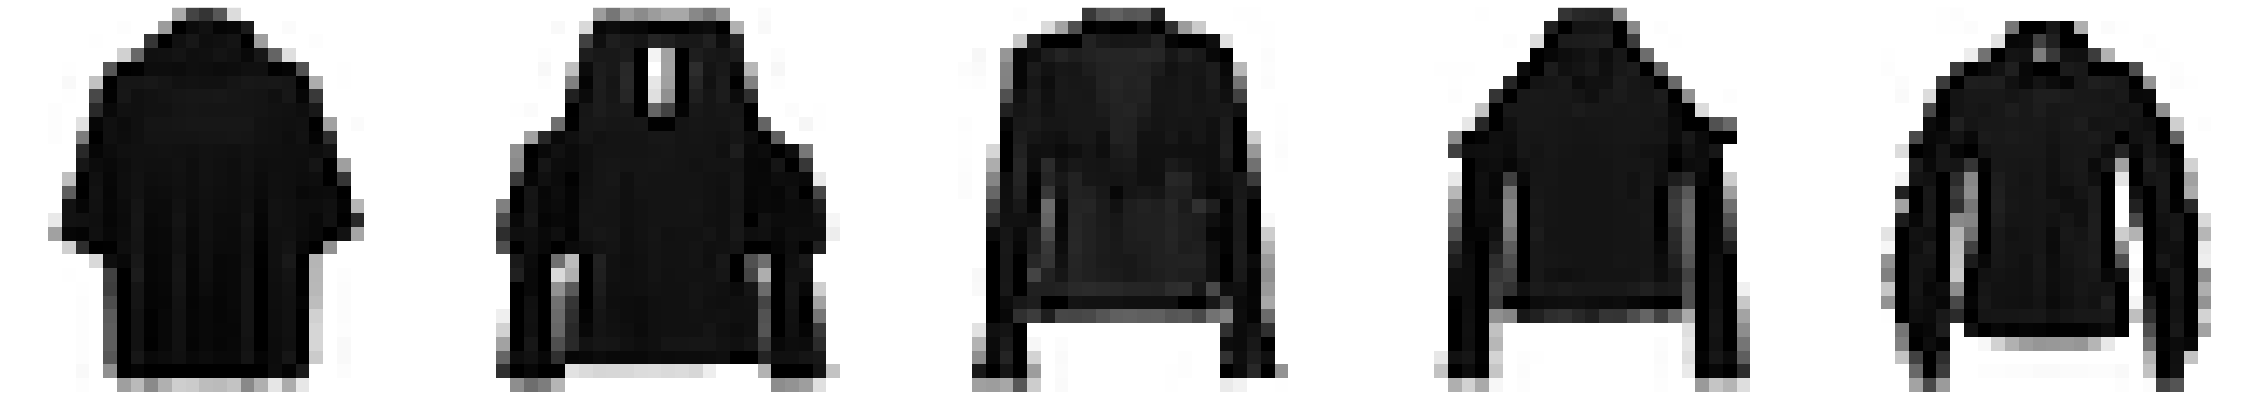

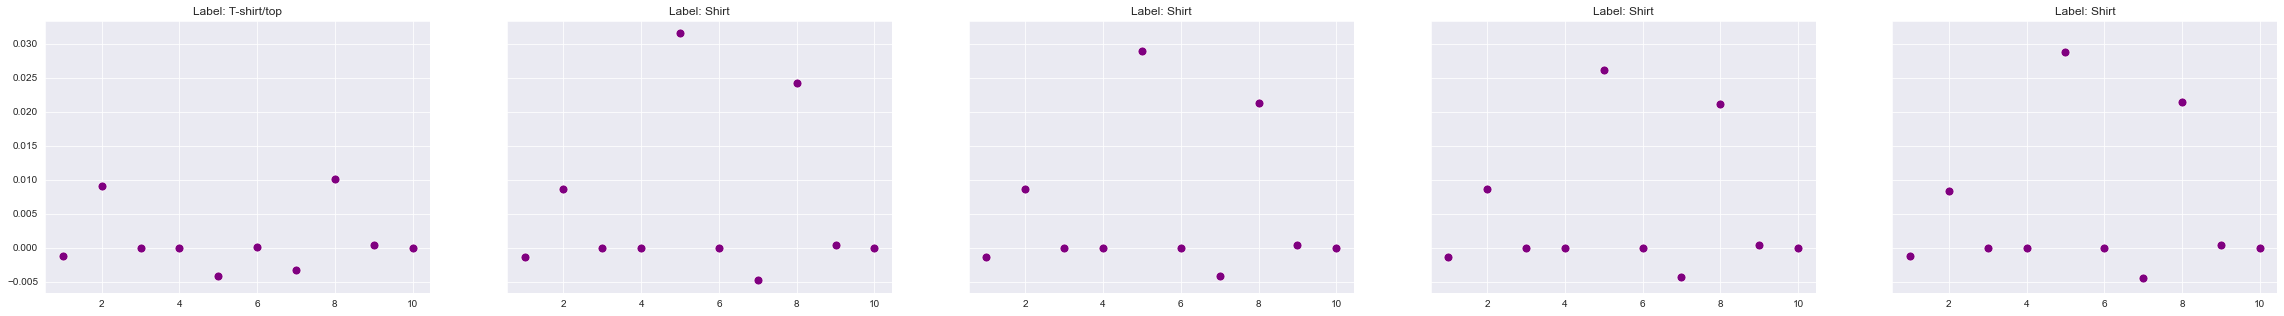

In [33]:
inf.plot_top_influencers(helpful,classes,training_data,influences,5)

In [34]:
training_data.targets

tensor([9, 0, 0,  ..., 3, 0, 5])